In [38]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
r=os.listdir( '/content/drive/MyDrive/Train/r')
o=os.listdir( '/content/drive/MyDrive/Train/o')

In [40]:
print('Dry images:',len(r),'Wet images:',len(o))

Dry images: 1100 Wet images: 971


In [41]:
r=r[:950]
o=o[:950]

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize
!pip install keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [43]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [44]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 1657 images belonging to 2 classes.


In [45]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 414 images belonging to 2 classes.


In [46]:
train_dataset.class_indices

{'o': 0, 'r': 1}

100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


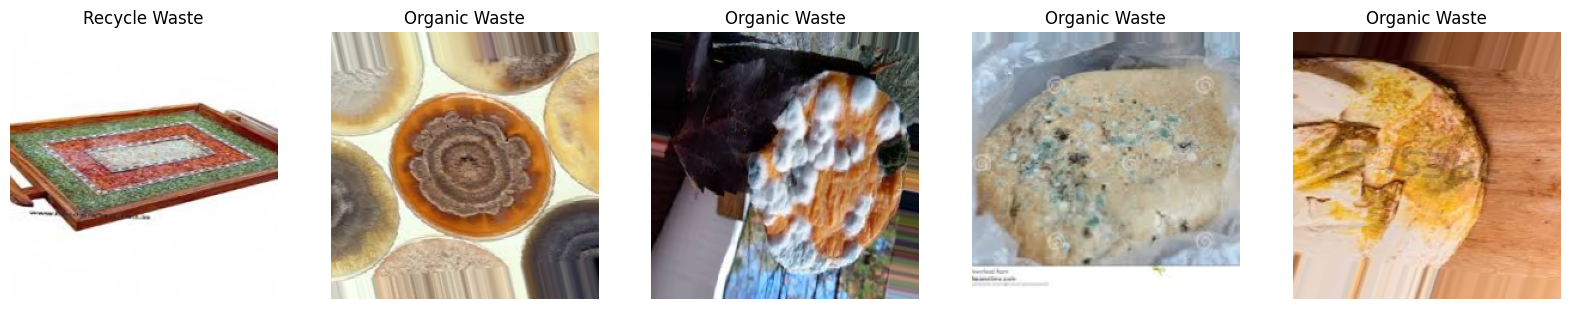

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

In [48]:
base_model = VGG16(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

In [49]:
for layer in base_model.layers:
    layer.trainable=False

In [50]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_6 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 1024)              25691136  
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                     

In [53]:
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [54]:
filepath = './model.h5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

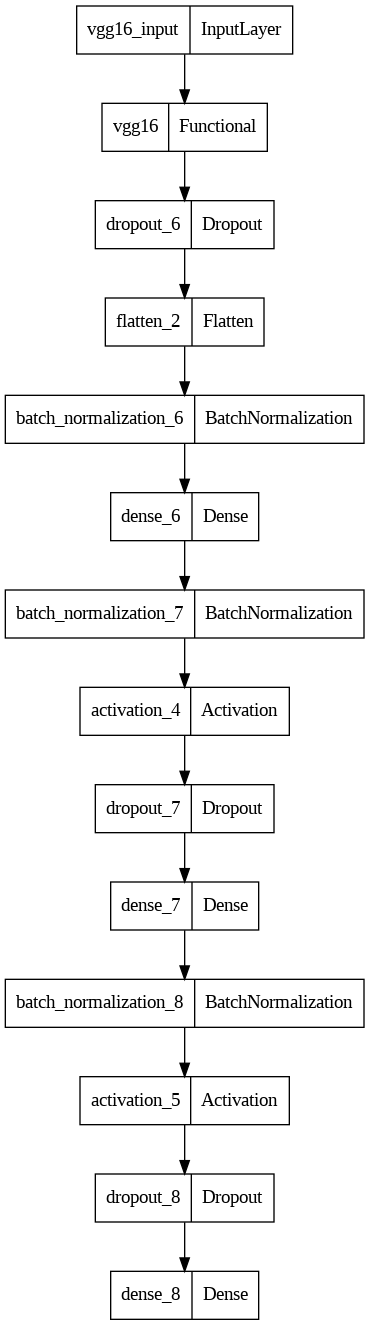

In [55]:
plot_model(model, to_file='model.png')

In [56]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.3474 - auc: 0.9429
Epoch 1: val_auc improved from -inf to 0.79425, saving model to ./model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 58s 4s/step - loss: 0.3474 - auc: 0.9429 - val_loss: 1.4345 - val_auc: 0.7942
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.1792 - auc: 0.9803
Epoch 2: val_auc did not improve from 0.79425
13/13 [==============================] - 33s 2s/step - loss: 0.1792 - auc: 0.9803 - val_loss: 1.1737 - val_auc: 0.7835
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.1408 - auc: 0.9872
Epoch 3: val_auc did not improve from 0.79425
13/13 [==============================] - 35s 3s/step - loss: 0.1408 - auc: 0.9872 - val_loss: 0.9235 - val_auc: 0.7717
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.1070 - auc: 0.9925
Epoch 4: val_auc improved from 0.79425 to 0.84695, saving model to ./model.h5
13/13 [==============================] - 38s 3s/step - loss: 0.1070 - auc: 0.9925 - val_loss: 0.6446 - val_auc: 0.8470
Epoch 5/10
13/13 [==============================] - ETA: 0s - loss: 0.1083 - auc: 0.992

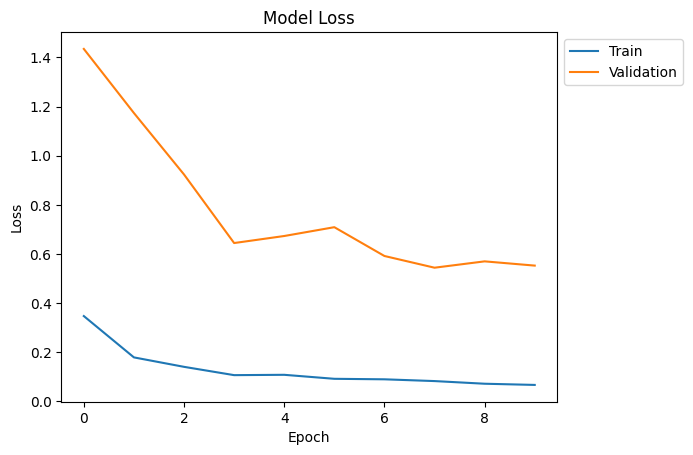

In [57]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


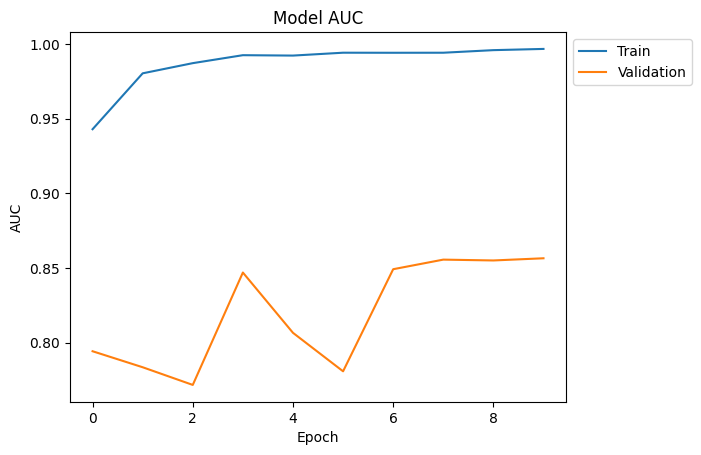

In [58]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


In [59]:
test_data = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Test',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 293 images belonging to 2 classes.


In [60]:
model.evaluate(test_data)

3/3 [==============================] - 52s 25s/step - loss: 0.4873 - auc: 0.8695


[0.48727408051490784, 0.8695335984230042]

1/1 [==============================] - 1s 1s/step
The image belongs to Organic waste category 


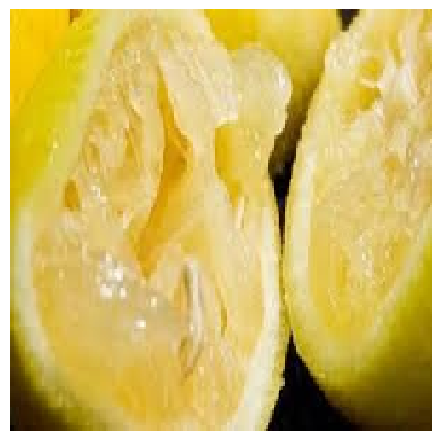

In [61]:
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Test/o/testing1.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")